In [1]:
import importlib
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import model
import train
import lossfn
import plots
from custom_dataset import CustomDataset
from preprocess import ClipTransform, ReplaceNaN
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision import transforms
from util import save_model, load_model, save_result, load_result
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_float32_matmul_precision('high') # better performance for float32 matrix multiplication
%load_ext autoreload
%autoreload 2

In [2]:
!nvidia-smi

Sun Aug 27 00:23:05 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.65.01    Driver Version: 515.65.01    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:17:00.0 Off |                    0 |
| N/A   49C    P0   301W / 300W |  51892MiB / 81920MiB |     73%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
|   1  NVIDIA A100 80G...  Off  | 00000000:31:00.0 Off |                    0 |
| N/A   

## Dataset and Dataloader

In [2]:
root_dir = './data/MDISC/small_dataset/train/train_v2d_alpha_cubic_512x512/'
labels_path = root_dir+'train_labels.txt'

width = 512
mean = [-3.5877]
std=[1.3475]

# transforms.ToTensor assumes input dimensions (H x W x C)
transform=transforms.Compose([transforms.ToTensor(),
                              torch.log,
                              ClipTransform(min_value=-21), #-inf resulted from log 0
                              ReplaceNaN(constant=-21), # NaN resulted from log -ve values
                              transforms.Normalize(mean=mean, std=std), # mean and std determined in `preprocess.ipynb`
                             ])
dataset = CustomDataset(root_dir=root_dir, labels_path=labels_path, transform=transform)

In [3]:
dataset[0][0].dtype, dataset[0][0].shape, len(dataset.labels)

(torch.float32, torch.Size([1, 512, 512]), 10201)

In [4]:
batch_size = 32
shuffle = True
num_workers = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=num_workers)

### Checking dataloader samples

torch.Size([32, 1, 512, 512]) (32,) kh1.26e+07_rmp92.50
Plotting kh1.26e+07_rmp92.50


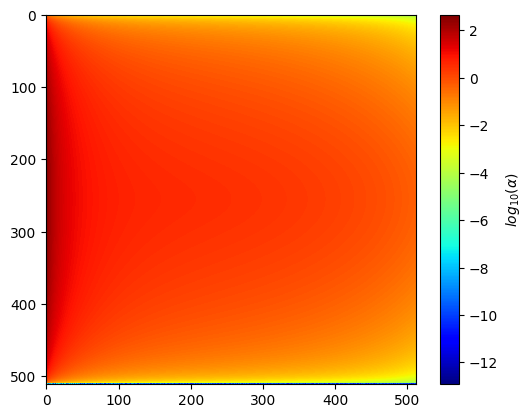

In [7]:
for x, y in dataloader:
    # Extract the data and labels from the batch
    x = x.to(device).float() # GPU
    y = np.array(y)
    print(x.shape, y.shape, y[0])
    break

print(f'Plotting {y[0]}')
fig, ax = plt.subplots()
s = plt.imshow(x[0].cpu().detach().numpy().squeeze(),
                cmap="jet")
plt.colorbar(s, label=r'$log_{10}(\alpha)$');

(tensor(0), torch.Size([512, 512]))

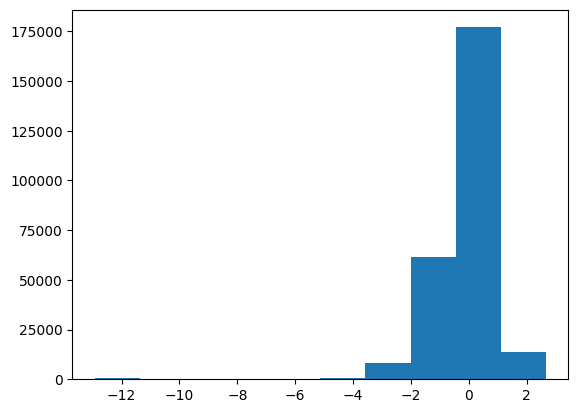

In [8]:
plt.hist(x[0][0].cpu().numpy().flatten()); np.isnan(x[0][0].cpu()).sum(), x[0][0].shape

## Model

In [5]:
from model import VAE

In [6]:
beta = 1.0
vae = VAE(image_channels=1, h_dim=256 * 1 * 1, z_dim=2, beta=beta, device=device)
vae = torch.compile(vae) # Pytorch 2.0 acceleration

## Training (+ wandb)

In [7]:
from train import train_model
import wandb

In [8]:
output_dir='my_model'
lr=1e-3
epochs=3000

# 1. Organize your hyperparameters
config = SimpleNamespace(# training hyperparameters
                         batch_size=batch_size, 
                         lr=lr,
                         epochs=epochs,
                         num_workers=num_workers,
                         
                         # network hyperparameters 
                         beta=beta,
                         )

In [9]:
wandb.login(anonymous="allow")

wandb: Currently logged in as: ikitcheng. Use `wandb login --relogin` to force relogin


True

In [ ]:
vae, hist = train_model(vae, dataloader, config, save_dir=f'./my_model/beta{beta}_epoch{epochs}_batchsize{batch_size}_lr{lr}/')

Checkpoint saved!
Checkpoint saved!
Checkpoint saved!
Checkpoint saved!
Epoch: 100/3000, Loss: 1012.8015
Checkpoint saved!
Checkpoint saved!
Checkpoint saved!


In [30]:
# save the model and history
save_model(vae.eval(), model_path=f'./my_model/beta{beta}_epoch{epochs}_batchsize{batch_size}_lr{lr}/vae_beta{beta}_epoch{epochs}_batchsize{batch_size}_lr{lr}.pth')
save_result(hist, filename=f'./my_model/beta{beta}_epoch{epochs}_batchsize{batch_size}_lr{lr}/hist_vae_beta{beta}_epoch{epochs}_batchsize{batch_size}_lr{lr}.pkl')